In [1]:
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import numpy as np 
from scipy.stats import gaussian_kde
import statsmodels.formula.api as smf
import pandas as pd

plt.clf()

def save_3d_surface(data, x_vec, y_vec, file_name, labels):
    '''
    Given a matrix of data saves out
    a 3D plot
    '''

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    y_mat, x_mat = np.meshgrid(y_vec, x_vec)

    ax.plot_surface(x_mat, y_mat, data)

    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.title(labels[2])
    plt.savefig(file_name)

Density evaluated at age=61; income group=6 is [0.00012784]


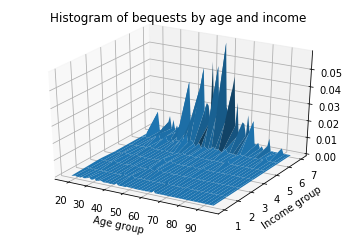

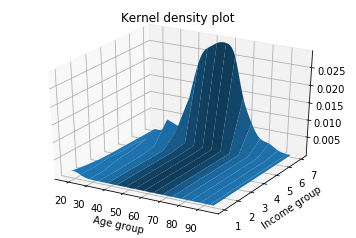

In [3]:
########################################
# Code for question #1: Kernels
########################################

bq_data = np.loadtxt('data/BQmat_orig.txt', delimiter=",")
x_vec = np.array(range(18,96))
y_vec = np.array(range(1,8))
labels_partA = ['Age group', 'Income group', 'Histogram of bequests by age and income']

save_3d_surface(bq_data, x_vec, y_vec, "3D_histogram.png", labels_partA)

# Get the probabilities for each of our two dimensions
prob_age_mat = bq_data.sum(axis=1)
prob_inc_mat = bq_data.sum(axis=0)

# Using the probs for each dim, generate counts 
sample_size = 1000
age_probs = np.random.multinomial(sample_size, prob_age_mat)
inc_probs = np.random.multinomial(sample_size, prob_inc_mat)

# create distribution of ages according to the given probs
age_freq = np.array([])
for age, num_s in zip(x_vec, age_probs):
    vec = np.full(num_s, age)
    age_freq = np.append(age_freq, vec)


# create distribution of inc groups accoding to the given probs
inc_freq = np.array([])
for inc, num_i in zip(y_vec, inc_probs):
    vec = np.full(num_i, inc)
    inc_freq = np.append(inc_freq, vec)

bandwidth = 1
data = np.vstack((age_freq, inc_freq))

# use default kernel 
density = gaussian_kde(data)

abils_mat, ages_mat = np.meshgrid(y_vec, x_vec)
coords = np.vstack([item.ravel() for item in [ages_mat, abils_mat]])
BQkde = density(coords).reshape(ages_mat.shape)
BQkde_scaled = BQkde / BQkde.sum()

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(ages_mat, abils_mat, BQkde_scaled, rstride =5)
ax.set_xlabel('Age group')
ax.set_ylabel('Income group')
ax.set_title('Kernel density plot')
plt.savefig('kernel_plot.png')

eval_point = density( (61, 6) )

print("Density evaluated at age=61; income group=6 is", eval_point)

Per the scipy.stats.gaussian_kde documentation, the bandwidth strongly influences the estimate obtained by KDE, even more so than the actual shape of the kernel. Ideally, I would so some sort of cross-validation approach but the default uses the 'Scott's Rule' heuristic and it appears that the above density plot captures the general dynamcis of the raw data, less some of the noise. This looks sufficient to me.

                            OLS Regression Results                            
Dep. Variable:                  biden   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     10.13
Date:                Mon, 30 Apr 2018   Prob (F-statistic):           1.29e-06
Time:                        08:24:30   Log-Likelihood:                -8333.3
No. Observations:                1826   AIC:                         1.667e+04
Df Residuals:                    1822   BIC:                         1.670e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     37.5491      9.491      3.956      0.0

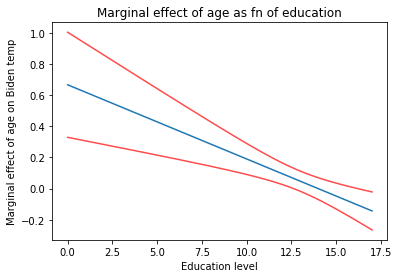

effect of age = 0.6674042441450919 + -0.04770936630667823*education_level


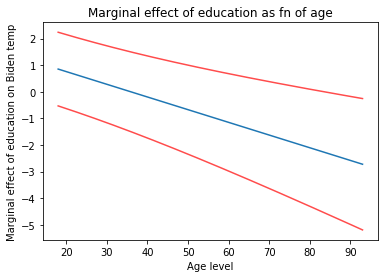

effect of educ = 1.7122930865988133 + -0.04770936630667823*age_level


In [7]:
##############################################################
# Code for question #2: Interaction terms in linear regression
##############################################################
df = pd.read_csv('data/biden.csv')

mod = smf.ols(formula='biden ~ age + educ + age*educ', data=df)
res = mod.fit()
print(res.summary())

# get min/max for plotting purposes, and coefficients, and var-cov estimates
min_age = df.age.min()
max_age = df.age.max()
age_vals = np.linspace(min_age, max_age, 200)

min_educ = df.educ.min()
max_educ = df.educ.max()
educ_vals = np.linspace(min_educ, max_educ, 200)

beta_age = res.params['age']
beta_educ = res.params['educ']
beta_mixed = res.params['age:educ']

var_cov = res.cov_params()
var_age = var_cov['age']['age']
var_educ = var_cov['educ']['educ']
var_mixed = var_cov['age:educ']['age:educ']
covar_age_mixed = var_cov['age']['age:educ']
covar_educ_mixed = var_cov['educ']['age:educ']

# marginal effect of age and education
age_marg = beta_age + beta_mixed*educ_vals
age_std = np.sqrt( var_age + (educ_vals**2)*var_mixed + 2*educ_vals*covar_age_mixed )
age_upper_band = age_marg + 2 * age_std
age_lower_band = age_marg - 2 * age_std

plt.clf()
plt.plot(educ_vals, age_marg)
plt.plot(educ_vals, age_upper_band, color='r', alpha=0.7)
plt.plot(educ_vals, age_lower_band, color='r', alpha=0.7)
plt.xlabel('Education level')
plt.ylabel('Marginal effect of age on Biden temp')
plt.title('Marginal effect of age as fn of education')
plt.show('marg_age.png')
print("effect of age = {} + {}*education_level".format(beta_age, beta_mixed))


educ_marg = beta_educ + beta_mixed*age_vals
educ_std = np.sqrt( var_educ + (age_vals**2)*var_mixed + 2*age_vals*covar_age_mixed )
age_upper_band = educ_marg + 2 * educ_std
age_lower_band = educ_marg - 2 * educ_std

plt.clf()
plt.plot(age_vals, educ_marg)
plt.plot(age_vals, age_upper_band, color='r', alpha=0.7)
plt.plot(age_vals, age_lower_band, color='r', alpha=0.7)
plt.xlabel('Age level')
plt.ylabel('Marginal effect of education on Biden temp')
plt.title('Marginal effect of education as fn of age')
plt.show('marg_educ.png')
print("effect of educ = {} + {}*age_level".format(beta_educ, beta_mixed))


When evaluating the marginal effect of age and education on the Biden-meter, because of the interaction terms the point estimate for the complete marginal effect will be a linear function of the interacted variable.

Below each graph I have included the corresponding linear function which is graphed above. For both variables, the marginal effect conditioned on the interacted-variable level being at its minimum (age level has floor of 18, so age=0 is nonsensical) is positive. However, the interaction coeffecient is negative, manifesting in a downward slope for each relationship above. So, the marginal effect of age on Biden-meter decreases as education increases. An analagous relationship holds with respect to education's marginal effect.

In addition to the point estimates, the variances are each a non-linear function of the level of the other variable. I have calculated the std error of each point estimate and plotted the +2 and -2 std error bounds in red in the graphs above. While the age marginal relationship remains, for the most part, statistically different from zero there is a region where it is not. Further, the education marginal effect is essentially never statistically signicantly different from zero. Very interesting find given that the regression coefficient outputs alone are all statistically significant.